In [15]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt


In [16]:
df1 = pd.read_csv('drive/MyDrive/cifar_x.csv')
df2 = pd.read_csv('drive/MyDrive/cifar_y.csv')

# neural nets in numpy:

In [17]:
def sigmoid(z):
    a = 1/(1 + np.exp(-z))
    return a

def relu(Z):
    z = np.copy(Z)
    np.maximum(z,0,z)
    return z

def leaky_relu(Z,slope=0.001):
    z = np.copy(Z)
    np.maximum(z,slope*z,z)
    return z

def derivative_leaky(a,slope=0.001):
    da = np.int64(a>0)*1 + np.int64(a<=0)*slope
    return da

def softmax(z):
    a = np.exp(z)/np.sum(np.exp(z),axis=0)
    return a

def derivative_relu(a):
    da = np.int64(a>0)*1
    return da

def derivative_sig(a):
    da = a * (1-a)
    return da

def initialize_parameters(layer_dims):
    # layer_dims is a list of nodes in each layer. architechture of the network
    # we are doing he-initialization
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1,L):
        parameters["W"+str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) * np.sqrt(2/layer_dims[l-1])
        parameters["b"+str(l)] = np.zeros((layer_dims[l],1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    
    return parameters    

def organize_activations(activations,L):
    #activations: list of strings of activations
    #L: no. of layers (excluding input)
    acts = {}
    if activations is None:
        for l in range(1,L):
            acts["act"+str(l)] = "relu"
        acts["act"+str(L)] = "sigmoid"
    else:
        for l in range(1,L+1):
            acts["act"+str(l)] = activations[l-1]
    return acts

def get_keep_probs(d):
    if d is None:
        return None
    else :
        d = np.array(d)
        a = 1-d
        return a
        

In [18]:
def find_z(A_prev,W,b):
    # A_prev: activation from prev layer
    # W,b: weights and bias of current layer
    
    z = np.dot(W,A_prev) + b
    
    assert(z.shape == (W.shape[0],A_prev.shape[1]))
    cache = (A_prev,W,b)
    
    return z,cache #cache format returned for a layer: (A_prev,W,b)

def forward_activation(A_prev,W,b,activation):
    z,cache = find_z(A_prev,W,b)
    
    if activation == "sigmoid":
        a = sigmoid(z)
    elif activation == "relu":
        a = relu(z)
    elif activation == "softmax":
        a = softmax(z)
    elif activation == "leaky_relu":
        a = leaky_relu(z)
    
    assert (a.shape == (W.shape[0], A_prev.shape[1]))
    cache = (cache,a)
    
    return a,cache #cache format for a layer: ((A_prev,W,b),A)

#feed forward network
def forward_propagation(X,parameters,acts=None):
    L = len(parameters)//2
    A = X
    caches = []
    
    if acts is None:
        acts = organize_activations(acts,L)
    
    for l in range(1,L):
        A_prev = A
        A,cache = forward_activation(A_prev,parameters["W"+str(l)],parameters["b"+str(l)],activation=acts["act"+str(l)])
        caches.append(cache)
        
    A_L,cache = forward_activation(A,parameters["W"+str(L)],parameters["b"+str(L)],activation=acts["act"+str(L)])
    caches.append(cache)
    
    return A_L,caches #caches is for each layer(except input): ((A_prev,W,b),A)

#forward prop with dropouts:
def forward_activation_with_dropouts(A_prev,W,b,activation,keep_prob):
    z,cache = find_z(A_prev,W,b)
    
    if activation == "sigmoid":
        a = sigmoid(z)
    elif activation == "relu":
        a = relu(z)
    elif activation == "softmax":
        a = softmax(z)
    elif activation == "leaky_relu":
        a = leaky_relu(z)
    
    #dropping out
    D = np.random.rand(a.shape[0],a.shape[1])
    D = D < keep_prob
    a = a * D
    a = a / keep_prob
    
    assert (a.shape == (W.shape[0], A_prev.shape[1]))
    cache = (cache,a,D)
    
    return a,cache #cache format for a layer: ((A_prev,W,b),A,D)

def forward_propagation_with_dropouts(X,parameters,keep_probs,acts=None):
    #keep_probs: list of keep_probs
    L = len(parameters)//2
    A = X
    caches = []
    
    if acts is None:
        acts = organize_activations(acts,L)
    
    for l in range(1,L):
        A_prev = A
        A,cache = forward_activation_with_dropouts(A_prev,parameters["W"+str(l)],parameters["b"+str(l)],activation=acts["act"+str(l)],keep_prob=keep_probs[l-1])
        caches.append(cache)
        
    A_L,cache = forward_activation_with_dropouts(A,parameters["W"+str(L)],parameters["b"+str(L)],activation=acts["act"+str(L)],keep_prob=1)
    caches.append(cache)
    
    return A_L,caches # caches for each layer: ((A_prev,W,b),A,D)

def loss(h,y):
    #L_sum = np.sum(y*np.log(h)) + np.sum((1-y)*(np.log(1-h)))
    #even if one prediction is way off then cost shoots up to inf. you can use any of the two eqns in this code
    L_sum = np.sum(np.log(h[y==1])) + np.sum(np.log(1-h[y==0]))
    m = y.shape[1]
    L = -(1/m) * L_sum

    return L

def loss_with_regularization(h,y,parameters,lambd):
    m = y.shape[1]
    L = len(parameters)//2
    cross_entropy_cost = loss(h,y)
    L2_regularization_cost = 0
    for l in range(L):
        L2_regularization_cost += np.sum(np.square(parameters["W"+str(l+1)]))
    L2_regularization_cost = lambd * L2_regularization_cost / (2*m)
    cost = cross_entropy_cost + L2_regularization_cost
    return cost

def find_grads(dz,cache,lambd):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = (np.dot(dz,A_prev.T) / m) + (lambd * W)/m
    db = np.sum(dz,axis=1,keepdims=True) / m
    dA_prev = np.dot(W.T,dz)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def linear_backwards(dA,cache,activation,lambd,keep_prop=None):
    if keep_prop is None:
        c,A = cache
    else:
        c,A,D = cache
        dA = dA * D
        dA = dA / keep_prop
        A = A * keep_prop # just to find accurate derivative for my defined functions. 
        #the above line won't matter in relu/leaky but better approximation for sigmoid
        
    if activation == "relu":
        dz = dA * derivative_relu(A)
    
    elif activation == "sigmoid":
        dz = dA * derivative_sig(A)
        
    elif activation == "leaky_relu":
        dz = dA * derivative_leaky(A)
     
    dA_prev, dW, db = find_grads(dz, c,lambd)
    return dA_prev,dW,db

def backprop(A_L,Y,caches,lambd,acts=None,keep_probs=None):
    grads = {}
    L = len(caches)
    m = A_L.shape[1]
    Y = Y.reshape(A_L.shape)
    
    if not acts:
        acts = organize_activations(acts,L)
    
    
    cache = caches[-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = find_grads((A_L-Y),cache[0],lambd)
    
    if keep_probs is None:
        for l in reversed(range(L-1)):
            cache = caches[l]
            grads["dA" + str(l)], grads["dW" + str(l+1)], grads["db" + str(l+1)] = linear_backwards(grads["dA"+str(l+1)],cache,activation=acts["act"+str(l+1)],lambd=lambd)
    
    else:
        for l in reversed(range(L-1)):
            cache = caches[l]
            grads["dA" + str(l)], grads["dW" + str(l+1)], grads["db" + str(l+1)] = linear_backwards(grads["dA"+str(l+1)],cache,activation=acts["act"+str(l+1)],lambd=lambd,keep_prop=keep_probs[l])
    
    return grads

def update_parameters(parameters,grads,learning_rate):
    L = len(parameters)//2
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

def random_mini_batches(X,Y,batch_size,shuffle):
    m = X.shape[1]
    batches = []
    
    if shuffle:
        permutation = list(np.random.permutation(m))
        shuffled_X = X[:,permutation]
        shuffled_Y = Y[:,permutation]
    
    else:
        shuffled_X = X
        shuffled_Y = Y
    
    for i in range(m//batch_size):
        mini_x = shuffled_X[:,i*batch_size:(i+1)*batch_size]
        mini_y = shuffled_Y[:,i*batch_size:(i+1)*batch_size]
        batch = (mini_x,mini_y)
        batches.append(batch)
    
    if m%batch_size !=0:
        mini_x = shuffled_X[:,batch_size*(m//batch_size):]
        mini_y = shuffled_Y[:,batch_size*(m//batch_size):]
        batch = (mini_x,mini_y)
        batches.append(batch)
    return batches

def initialize_adam(parameters):
    L = len(parameters)//2
    v = {}
    s = {}
    
    for l in range(L):
        v["dW"+str(l+1)] = np.zeros_like(parameters["W"+str(l+1)])
        v["db"+str(l+1)] = np.zeros_like(parameters["b"+str(l+1)])
        
        s["dW"+str(l+1)] = np.zeros_like(parameters["W"+str(l+1)])
        s["db"+str(l+1)] = np.zeros_like(parameters["b"+str(l+1)])
        
    return v,s

def update_parameters_with_adam(parameters,grads,v,s,t,lr=0.01,beta1=0.9,beta2=0.999,epsilon=1e-7):
    L = len(parameters)//2
    v_corrected = {}
    s_corrected = {}
    
    for l in range(L):
        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads['dW' + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]
        
        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * np.power(grads['dW' + str(l + 1)], 2)
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * np.power(grads['db' + str(l + 1)], 2)
        
        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - np.power(beta1, t))
        
        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - np.power(beta2, t))
        
        parameters["W"+str(l+1)] = parameters["W"+str(l+1)] - lr * (v_corrected["dW"+str(l+1)]/np.sqrt(s_corrected["dW"+str(l+1)]+epsilon))
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)] - lr * (v_corrected["db"+str(l+1)]/np.sqrt(s_corrected["db"+str(l+1)]+epsilon))
        
    return parameters,v,s  

def predict(X,Y,parameters):
    Y_pred,c = forward_propagation(X,parameters)
    prediction = np.argmax(Y_pred, axis=0)
    labels = np.argmax(Y, axis=0)

    diff=prediction-labels 
    accuracy = 1.0 - (float(np.count_nonzero(diff)) / len(diff))
    print(accuracy*100) 


In [45]:
def fit(X,Y,layer_dims,parameters=None,activations=None,validation_data=None,drop_probs=None,lr=0.01,beta1=0.9,beta2=0.999,lambd=0,epochs=3,batch_size=256,shuffle=True,optimizer="adam",print_cost=0):
    costs = []
    m = X.shape[1]
    t=0
#     if not parameters:
#         try:
#             parameters
#         except NameError:
#             parameters = initialize_parameters(layer_dims)
    if parameters is None:
        parameters = initialize_parameters(layer_dims)
    
    acts = organize_activations(activations,len(layer_dims)-1)
    
    if optimizer=="adam":
        v,s = initialize_adam(parameters)
        
    keep_probs = get_keep_probs(drop_probs)
        
    for i in range(epochs):
        cost = 0
        mini_batches = random_mini_batches(X,Y,batch_size,shuffle)
        for batch in mini_batches:
            (mini_x,mini_y) = batch
            if keep_probs is None:
                A_L,caches = forward_propagation(mini_x,parameters,acts)
            else:
                A_L,caches = forward_propagation_with_dropouts(mini_x,parameters,acts=acts,keep_probs=keep_probs)
            cost += loss_with_regularization(A_L,mini_y,parameters=parameters,lambd=lambd) #default lambd=0. 
            grads = backprop(A_L,mini_y,caches,acts=acts,lambd=lambd,keep_probs=keep_probs)
            #update parameters:
            if optimizer=="adam":
                t = t+1
                parameters,v,s = update_parameters_with_adam(parameters,grads,v,s,t,lr,beta1,beta2)
            else:
                parameters = update_parameters(parameters,grads,lr)
        
        cost = cost/len(mini_batches)
        if print_cost!=0 and i % print_cost == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
            predict(X,Y,parameters)
            if validation_data is not None:
              predict(validation_data[0],validation_data[1],parameters)
        if print_cost!=0 and i % print_cost == 0:
            costs.append(cost)
    return parameters

# importing cifar data

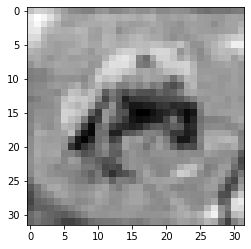

In [28]:
#CIFAR

x = np.array(df1)
y_ = np.array(df2)
x = x.reshape((1024,60000))
y_ = y_.reshape((10,60000))
x = x/255.0 
#separating train and test
x_train = x[:,:-10000]
x_test = x[:,-10000:]
y_test = y_[:,-10000:]
y_train = y_[:,:-10000]

x_train = x_train.T
x_test = x_test.T
x_train = x_train.reshape((50000,32,32))
x_test = x_test.reshape((10000,32,32))
# x_train = tf.keras.utils.normalize(x_train, axis=1)
# x_test = tf.keras.utils.normalize(x_test, axis=1)
plt.imshow(x_train[0],cmap=plt.cm.binary)

x_train = x_train.reshape((50000,1024))
x_train = x_train.T
x_test = x_test.reshape((10000,1024))
x_test = x_test.T

# training:

In [47]:
lay = [x_train.shape[0],512,10]
try:
  p
except NameError:
  p =  initialize_parameters(lay)
a = ['relu',"sigmoid"]
drops = None
p = fit(x_train,y_train,layer_dims=lay,activations=a,parameters=p,validation_data=(x_test,y_test),drop_probs=drops,lr=0.001,epochs=1,print_cost=1)

Cost after iteration 0: 2.262942
50.38199999999999
43.02


In [48]:
predict(x_train,y_train,p)
predict(x_test,y_test,p)

50.38199999999999
43.02


In [40]:
p = initialize_parameters(lay)

In [5]:
!pip install numba
!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'
from numba import jit, njit, vectorize, cuda

/usr/local/cuda-10.0/nvvm/libdevice
/usr/local/cuda-10.1/nvvm/libdevice
/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so
/usr/local/cuda-10.1/nvvm/lib64/libnvvm.so


In [15]:
@jit
def lol(a,b):
  return a+b

In [16]:
%timeit for i in range(100): a+b

1 loop, best of 3: 5.29 s per loop
